# Analyzing HRIXS data

HRIXS spectra are, at the base, one dimensional spectra. They are recorded on a 2 D camera. The complication is that due to abberations, the spectra do not show up as straight lines on the camera, but are curved. These abberations need to be corrected for data analyis.

We start with importing all necessary:

In [1]:
import numpy as np
import xarray as xa

import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2
from toolbox_scs.detectors.hrixs import hRIXS

## Setting the stage

we start by creating an hRIXS object. It contains all the gory details about the experiment, but no data.

All those parameters need to be carefully calibrated whenever the spectrometer is moved, usually at the beginning of a beamtime.

In [2]:
h = hRIXS()
h.PROPOSAL = 3154  # the current proposal number
h.Y_RANGE = slice(700, 900)  # the range of the camera the data is in. Y is the "energy" axis
h.CURVE_B = -3.695346575286939e-07  # the curvature as determined elsewhere (see later)
h.CURVE_A = 0.024084479232443695
h.ENERGY_SLOPE = 0.018387  # the energy calibration
h.ENERGY_INTERCEPT = 498.27
h.STD_THRESHOLD = 3.5  # threshold above which a peak is considered a peak, in standard deviations above noise level

## reading the data

now we can read the data. There are two different ways to analyze the data: for low intensities, we can do single photon counting, for high intensities as simple integration is better. No matter which method, all data is read into an xarray DataSet, and further treated therein.

### Centroiding

The centroiding algorithm then finds single photons, creates as spectrum and adds that to the DataSet. The parameters for the centroiding only need to be set once.

In [3]:
data = h.from_run(2)  # just load run No 2

h.BINS = 500  # number of bins to centroid into

h.centroid(data)

<xarray.Dataset>
Dimensions:      (energy: 500, trainId: 6, x: 2048, y: 2048)
Coordinates:
  * trainId      (trainId) uint64 1531618246 1531618389 ... 1531618962
  * energy       (energy) float64 511.1 511.1 511.2 511.2 ... 514.8 514.8 514.8
Dimensions without coordinates: x, y
Data variables:
    hRIXS_det    (trainId, x, y) uint16 595 561 595 588 603 ... 625 645 630 635
    hRIXS_index  (trainId) int32 6 6 6 6 6 6
    hRIXS_delay  (trainId) float32 0.15 0.15 0.15 0.15 0.15 0.15
    hRIXS_norm   (trainId) float32 7.0124035 7.4794917 ... 5.220501 4.259891
    spectrum     (trainId, energy) float64 0.0 0.0 0.0 1.0 ... 0.0 0.0 0.0 0.0
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202202/p003154/raw/r0002

### Integration

for higher intensities, when single photons are not visible anymore, we just integrate over pixels with the same energy.

In [4]:
data = h.from_run(2)  # just load run No 2
h.integrate(data)

<xarray.Dataset>
Dimensions:      (energy: 180, trainId: 6, x: 2048, y: 2048)
Coordinates:
  * trainId      (trainId) uint64 1531618246 1531618389 ... 1531618962
  * energy       (energy) float64 511.3 511.3 511.4 511.4 ... 514.6 514.6 514.6
Dimensions without coordinates: x, y
Data variables:
    hRIXS_det    (trainId, x, y) uint16 595 561 595 588 603 ... 625 645 630 635
    hRIXS_index  (trainId) int32 6 6 6 6 6 6
    hRIXS_delay  (trainId) float32 0.15 0.15 0.15 0.15 0.15 0.15
    hRIXS_norm   (trainId) float32 7.0124035 7.4794917 ... 5.220501 4.259891
    spectrum     (trainId, energy) float64 637.9 638.8 638.6 ... 640.0 639.3
Attributes:
    runFolder:  /gpfs/exfel/exp/SCS/202202/p003154/raw/r0002

## Plotting

we employ xarray also for plotting. As a first example, we just integrate over all trains in a run, thus ignoring any possible delay or energy scan.

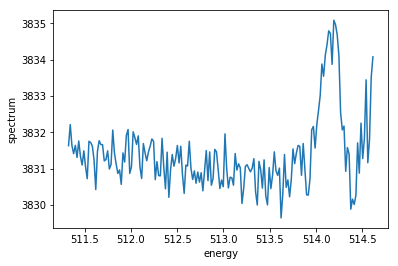

In [5]:
agg = h.aggregate(data)  # sum spectra for all trains
agg.spectrum.plot()

## Delay scans

we make full use of xarray to select for parameters we scan over, in this example a pump-probe dela. "hRIXS_index" is an index into the table of delays, as it is an integer it makes it easier to group the data. Ideally, this index should also be used for all other types of scans, like energy scans, this is why the nameOne may then reduce the data, summing all corresponding images.

In [6]:
gr = data.groupby('hRIXS_index', squeeze=True)
delays = gr.map(h.aggregate)
delays

<xarray.Dataset>
Dimensions:      (energy: 180, hRIXS_index: 1, x: 2048, y: 2048)
Coordinates:
  * energy       (energy) float64 511.3 511.3 511.4 511.4 ... 514.6 514.6 514.6
  * hRIXS_index  (hRIXS_index) int64 6
Dimensions without coordinates: x, y
Data variables:
    hRIXS_det    (hRIXS_index, x, y) uint64 3623 3320 3557 ... 3844 3816 3800
    hRIXS_delay  (hRIXS_index) float32 0.14999999
    hRIXS_norm   (hRIXS_index) float32 38.10606
    spectrum     (hRIXS_index, energy) float64 3.832e+03 3.832e+03 ... 3.834e+03

Instead of reducing all data at once, one can also just look at one delay. The first axis (the 0 in the example) is the index in the delay scan table, so the 0 means: take the data for the 0th delay in the list of delays.

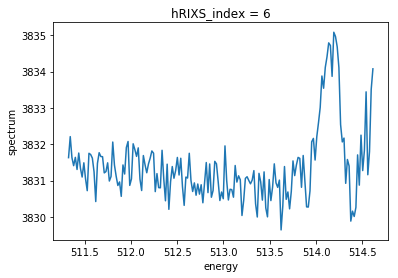

In [7]:
delays.spectrum[0, :].plot()

## adding up several runs

Data of different runs can be concatenated

In [8]:
data2 = h.from_run(3)
data2 = h.centroid(data2)

datas = xa.concat((data, data2), 'trainId')

## finding the curvature

there is an automatic procedure to find the curvature for an HRIXS operation point.
The method `find_curvature` takes a run, integrates the images and fits the curvature parameters to it. During the fit, it will use the current curvature as starting values. It outputs the new curvature parameters, together with a plot of the curvature overlayed on top of the data, where the starting values are shown in blue, while the fitted curve is in orange.


(0.01934392725990066, -3.2404000959549933e-07)

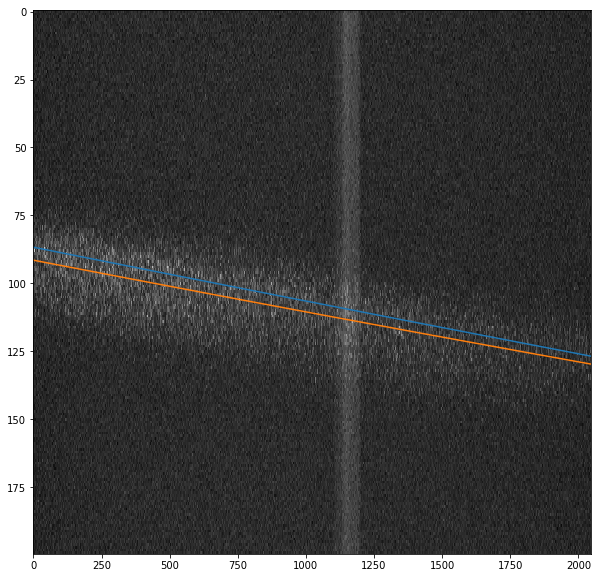

In [9]:
h.Y_RANGE = slice(700, 900)  # tell the algorithm where the data actually is
h.find_curvature(1, 3485)  # use run 1 of proposal 3485 to fit the curvature